# Case Study: Building a production-ready recommendation engine for a new customer

**Author:** Ruhollah Jamali 

**Date:** November 2025

---

## Executive Summary

This notebook presents a complete solution for three key recommendation scenarios:
1. **Top-Seller Products**
2. **Frequently Bought Together (FreBoTo)**
3. **Real-time Personalized Recommendations**


### Dataset
We're using the [Otto RecSys Challenge dataset](https://www.kaggle.com/datasets/otto/recsys-dataset), which contains ~12M e-commerce sessions with click, cart, and purchase events. 


## Libraries

In [1]:
# data processing
import polars as pl
import os
import numpy as np
import pandas as pd
from pathlib import Path
import json
from datetime import datetime
from collections import Counter, defaultdict
import kaggle
import zipfile
import subprocess
import pyarrow.parquet as pq
import pyarrow.parquet as pq


# ML and similarity computation
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix, save_npz, load_npz
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

from graphviz import Digraph

# API
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List

# For persistence and model saving
import joblib

# Suppress warnings for clean output
import warnings
warnings.filterwarnings('ignore')

## Project setup

In [2]:
# Configure project directories
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
MODELS_DIR = BASE_DIR / 'models'
OUTPUT_DIR = BASE_DIR / 'output'

# Create dirs if they don't exist
for directory in [DATA_DIR, MODELS_DIR, OUTPUT_DIR]:
    directory.mkdir(exist_ok=True)


# Data loading and understanding

## Download dataset from Kaggle

In [3]:
# Download the dataset using the Kaggle API.
DATA_DIR.mkdir(parents=True, exist_ok=True)
dataset_slug = "otto/recsys-dataset"
target_filename = "otto-recsys-train.jsonl"
target_path = DATA_DIR / target_filename

# Set up environment variable if needed
os.environ.setdefault("KAGGLE_CONFIG_DIR", str(Path.home() / ".kaggle"))

# Download dataset file if not already present
if not target_path.exists():
    print("Downloading dataset from Kaggle...")
    subprocess.run([
        "kaggle", "datasets", "download",
        "-d", dataset_slug,
        "-f", target_filename,
        "-p", str(DATA_DIR)
    ], check=True)
    
    # Unzipping the file using Python's zipfile
    for file in DATA_DIR.glob("*.zip"):
        print('unzip')
        print(f"Extracting {file.name}...")
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)
        file.unlink()  # Remove the zip file after extraction
    
    print("Download completed and file ready in data/ folder.")
else:
    print("Dataset already exists in data/ folder, skipping download.")

Dataset already exists in data/ folder, skipping download.


## Data conversion from JSONL to Parquet

In [4]:
data_file = DATA_DIR / "otto-recsys-train.jsonl"

def convert_jsonl_to_parquet_streaming():
    jsonl_path = DATA_DIR / 'otto-recsys-train.jsonl'
    parquet_path = DATA_DIR / 'train_full.parquet'

    print("Converting JSONL to Parquet")

    BATCH_SIZE = 50000 
    batch = []
    writer = None
    schema = None
    total_events = 0
    total_lines = 0

    with open(jsonl_path, 'r') as f:
        for line in f:
            total_lines += 1
            record = json.loads(line)

            # Flatten nested events
            for event in record['events']:
                batch.append({
                    'session_id': record['session'],
                    'item_id': event['aid'],
                    'ts': event['ts'],
                    'event_type': event['type']
                })

                # When batch is full, write to parquet
                if len(batch) >= BATCH_SIZE:
                    table = pa.Table.from_pylist(batch)

                    if writer is None:
                        # First batch: create writer with schema
                        schema = table.schema
                        writer = pq.ParquetWriter(parquet_path, schema)

                    writer.write_table(table)
                    total_events += len(batch)
                    batch.clear()

                    if total_lines % 10000 == 0:
                        print(f"  Processed {total_lines:,} sessions, {total_events:,} events...")

    # Write remaining batch
    if batch:
        table = pa.Table.from_pylist(batch)
        if writer is None:
            schema = table.schema
            writer = pq.ParquetWriter(parquet_path, schema)
        writer.write_table(table)
        total_events += len(batch)
        batch.clear()

    if writer:
        writer.close()

    print(f"Conversion complete! {total_events:,} events saved to Parquet")
    return parquet_path

source_parquet = DATA_DIR / 'train_full.parquet'

if not source_parquet.exists():
    print("Source parquet not found, converting from JSONL...")
    convert_jsonl_to_parquet_streaming()

## Load and inspect raw data

In [5]:
meta = pq.read_metadata(source_parquet)
print(f"[data] Parquet file: {source_parquet.name}")
print(f"[data] Row groups: {meta.num_row_groups:,}, Total rows: {meta.num_rows:,}")
print(f"[data] Columns: {[meta.schema.names[i] for i in range(meta.num_columns)]}")

[data] Parquet file: train_full.parquet
[data] Row groups: 4,335, Total rows: 216,716,096
[data] Columns: ['session_id', 'item_id', 'ts', 'event_type']


In [6]:
reader = pq.ParquetFile(source_parquet)

# Choose a few row groups to sample (depends on available memory)
n_groups = min(3, reader.num_row_groups)
sample_tables = [reader.read_row_group(i) for i in range(n_groups)]
sample_df = pl.concat([pl.from_arrow(tbl) for tbl in sample_tables])

print(f"[data] Sampled {len(sample_df):,} rows from {n_groups} row groups (~{100 * n_groups / reader.num_row_groups:.2f}% of dataset).")

# Compute simple descriptive stats
print("\n[data] Descriptive statistics on sample:")
print(sample_df.describe())

# Optional: event distribution (categorical overview)
if "type" in sample_df.columns:
    print("\n[data] Event type distribution:")
    print(sample_df["type"].value_counts().to_pandas())

[data] Sampled 150,000 rows from 3 row groups (~0.07% of dataset).

[data] Descriptive statistics on sample:
shape: (9, 5)
┌────────────┬────────────┬───────────────┬───────────┬────────────┐
│ statistic  ┆ session_id ┆ item_id       ┆ ts        ┆ event_type │
│ ---        ┆ ---        ┆ ---           ┆ ---       ┆ ---        │
│ str        ┆ f64        ┆ f64           ┆ f64       ┆ str        │
╞════════════╪════════════╪═══════════════╪═══════════╪════════════╡
│ count      ┆ 150000.0   ┆ 150000.0      ┆ 150000.0  ┆ 150000     │
│ null_count ┆ 0.0        ┆ 0.0           ┆ 0.0       ┆ 0          │
│ mean       ┆ 946.858633 ┆ 927869.98524  ┆ 1.6602e12 ┆ null       │
│ std        ┆ 570.758656 ┆ 535049.196347 ┆ 7.6404e8  ┆ null       │
│ min        ┆ 0.0        ┆ 114.0         ┆ 1.6593e12 ┆ carts      │
│ 25%        ┆ 474.0      ┆ 467667.0      ┆ 1.6594e12 ┆ null       │
│ 50%        ┆ 939.0      ┆ 927947.0      ┆ 1.6600e12 ┆ null       │
│ 75%        ┆ 1436.0     ┆ 1.390803e6    ┆ 1.660

## Preprocessing

In [7]:
# Load data directly from source parquet (keeps original columns)
df_raw = pl.scan_parquet(source_parquet)

# Check if processed version already exists
processed_path = DATA_DIR / 'train_full_processed.parquet'

if not processed_path.exists():
    print("Preprocessing data and saving it on the disk...")

    # Build preprocessing pipeline
    df_processed = (
        df_raw
        .with_columns([
            pl.col("event_type").cast(pl.Categorical),
            pl.from_epoch(pl.col('ts'), time_unit='ms').alias('event_time')
        ])
        .select(['session_id', 'item_id', 'event_time', 'event_type'])
    )

    # Write directly to disk 
    print("Writing to parquet...")
    df_processed.sink_parquet(processed_path, compression='snappy', row_group_size=100000)
    print(f"Preprocessed data saved to {processed_path.name}")
else:
    print(f"Preprocessed data already exists at {processed_path.name}")

# Work with the processed data
df_final = pl.scan_parquet(processed_path)

# Verify the file is valid
verification_count = df_final.select(pl.len()).collect().item()
print(f"Preprocessed data is ready and it has: {verification_count:,} records")

Preprocessed data already exists at train_full_processed.parquet
Preprocessed data is ready and it has: 216,716,096 records


## Load and inspect preprocessed data

In [8]:
print("Event type Distribution:")
event_counts = (
    df_final
    .group_by('event_type')
    .agg(pl.len().alias('count'))
    .sort('count', descending=True)
    .collect()
)
print(event_counts)

# Session length analysis
print("\nSession analysis:")
session_stats = (
    df_final
    .group_by('session_id')
    .agg(pl.len().alias('events_per_session'))
    .select([
        pl.col('events_per_session').mean().alias('avg_events'),
        pl.col('events_per_session').median().alias('median_events'),
        pl.col('events_per_session').max().alias('max_events'),
        pl.col('events_per_session').min().alias('min_events')
    ])
    .collect()
)
print(session_stats)

# Item popularity overview
print("\nTop 10 Most interacted items")
top_items = (
    df_final
    .group_by('item_id')
    .agg(pl.len().alias('interactions'))
    .sort('interactions', descending=True)
    .head(10)
    .collect()
)
print(top_items)

# Basic dataset info
print("\nDataset schema")
schema_sample = df_final.head(5).collect()
print(f"Columns: {schema_sample.columns}")
print(f"Data types: {schema_sample.dtypes}")
print("\nSample records:")
print(schema_sample)

Event type Distribution:
shape: (3, 2)
┌────────────┬───────────┐
│ event_type ┆ count     │
│ ---        ┆ ---       │
│ cat        ┆ u32       │
╞════════════╪═══════════╡
│ clicks     ┆ 194720954 │
│ carts      ┆ 16896191  │
│ orders     ┆ 5098951   │
└────────────┴───────────┘

Session analysis:
shape: (1, 4)
┌────────────┬───────────────┬────────────┬────────────┐
│ avg_events ┆ median_events ┆ max_events ┆ min_events │
│ ---        ┆ ---           ┆ ---        ┆ ---        │
│ f64        ┆ f64           ┆ u32        ┆ u32        │
╞════════════╪═══════════════╪════════════╪════════════╡
│ 16.799985  ┆ 6.0           ┆ 500        ┆ 2          │
└────────────┴───────────────┴────────────┴────────────┘

Top 10 Most interacted items
shape: (10, 2)
┌─────────┬──────────────┐
│ item_id ┆ interactions │
│ ---     ┆ ---          │
│ i64     ┆ u32          │
╞═════════╪══════════════╡
│ 1460571 ┆ 129004       │
│ 485256  ┆ 126836       │
│ 108125  ┆ 118524       │
│ 29735   ┆ 113279       

## Feature Engineering

In [9]:
print("Creating aggregated features for recommendation models...")

# Calculate item popularity metrics across all events
print("Computing item popularity scores...")

item_stats = (
    df_final
    .group_by('item_id')
    .agg([
        pl.len().alias('total_interactions'),
        pl.col('event_type').filter(pl.col('event_type') == 'clicks').len().alias('clicks'),
        pl.col('event_type').filter(pl.col('event_type') == 'carts').len().alias('carts'),
        pl.col('event_type').filter(pl.col('event_type') == 'orders').len().alias('orders'),
    ])
    .with_columns([
        # Weighted popularity score: orders worth more than clicks
        (pl.col('orders') * 3 + pl.col('carts') * 2 + pl.col('clicks')).alias('popularity_score')
    ])
    .sort('popularity_score', descending=True)
)

# Save item statistics for later use
item_stats_path = OUTPUT_DIR / 'item_popularity_stats.parquet'
print(f"Saving item statistics to {item_stats_path.name}...")
item_stats.sink_parquet(item_stats_path)

Creating aggregated features for recommendation models...
Computing item popularity scores...
Saving item statistics to item_popularity_stats.parquet...


# Applicaitons implementation

## Top-Seller Products Model

### Model

In [10]:
print("Finding top seller products")

# Load the precomputed item stats
item_stats_df = pl.read_parquet(OUTPUT_DIR / 'item_popularity_stats.parquet')

purchase_based = (item_stats_df.filter(pl.col('orders') > 0).with_columns([(pl.col('orders')).alias('purchase_freqency')])
                    .sort('purchase_freqency', descending=True)
                    .head(100))

print(purchase_based.head(50).select(['item_id', 'purchase_freqency', 'orders', 'carts', 'clicks']))
# Save model
purchase_model_path = MODELS_DIR / 'top_sellers_purchase.parquet'
purchase_based.write_parquet(purchase_model_path)
print(f"\n\nModels saved: {purchase_model_path.name}")


Finding top seller products
shape: (50, 5)
┌─────────┬───────────────────┬────────┬───────┬────────┐
│ item_id ┆ purchase_freqency ┆ orders ┆ carts ┆ clicks │
│ ---     ┆ ---               ┆ ---    ┆ ---   ┆ ---    │
│ i64     ┆ u32               ┆ u32    ┆ u32   ┆ u32    │
╞═════════╪═══════════════════╪════════╪═══════╪════════╡
│ 231487  ┆ 4485              ┆ 4485   ┆ 10393 ┆ 64994  │
│ 166037  ┆ 3824              ┆ 3824   ┆ 13476 ┆ 67357  │
│ 1733943 ┆ 3042              ┆ 3042   ┆ 10654 ┆ 91395  │
│ 1445562 ┆ 2998              ┆ 2998   ┆ 5745  ┆ 12888  │
│ 1022566 ┆ 2788              ┆ 2788   ┆ 9338  ┆ 51045  │
│ …       ┆ …                 ┆ …      ┆ …     ┆ …      │
│ 180910  ┆ 1529              ┆ 1529   ┆ 3553  ┆ 21758  │
│ 1531805 ┆ 1464              ┆ 1464   ┆ 4435  ┆ 44571  │
│ 898836  ┆ 1460              ┆ 1460   ┆ 2609  ┆ 14281  │
│ 432989  ┆ 1443              ┆ 1443   ┆ 3036  ┆ 23846  │
│ 1406660 ┆ 1437              ┆ 1437   ┆ 4405  ┆ 33640  │
└─────────┴──────────────────

### API function for top-seller

In [11]:
# Create improved API function
# This function retrieve top n selling products
def get_top_sellers(n=10):
    df = pl.read_parquet(MODELS_DIR / 'top_sellers_purchase.parquet')
    return df.head(n)['item_id'].to_list()

# Test API
print(f"\n\nAPI Test - Top 20 sellers: {get_top_sellers(20)}")

# Save model metadata
model_metadata = {
    'model_name': 'top_sellers',
    'model_version': '1.0',
    'created_at': pd.Timestamp.now().isoformat(),
    'strategies': {
        'purchase': {
            'description': 'Items with purchases frequency',
            'total_products': len(purchase_based)
        },
    },
    'recommendation': 'Use purchase-based for homepage/main recommendations'
}

with open(MODELS_DIR / 'top_sellers_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("\n\nModel metadata saved")




API Test - Top 20 sellers: [231487, 166037, 1733943, 1445562, 1022566, 801774, 1629608, 756588, 332654, 1603001, 409620, 1257293, 1125638, 986164, 1083665, 450505, 544144, 1025795, 125278, 29735]


Model metadata saved


## Frequently bought together (FreBoTo)

###  Data Preparation

In [12]:
print("Building Frequently Bought Together Model")

# We need to find items that appear together in the same session while focusing on purchase events for true buying patterns

print("Extracting co-occurrence patterns from purchase sessions...")

# Get sessions with orders only
order_sessions = (df_final.filter(pl.col('event_type') == 'orders').select(['session_id', 'item_id']).unique())

# Also we count sessions per item to filter out very rare items
print("Filtering out rare items to improve model quality...")

item_session_counts = (order_sessions.group_by('item_id').agg(pl.len().alias('session_count'))
                            .filter(pl.col('session_count') >= 3) )  # Item must appear in at least 3 sessions

# Filter sessions to only include popular enough items
filtered_sessions = (order_sessions.join(item_session_counts, on='item_id', how='inner')
                        .select(['session_id', 'item_id']))

# Save for co-occurrence computation
sessions_path = OUTPUT_DIR / 'order_sessions.parquet'
print(f"Saving filtered order sessions to {sessions_path.name}...")
filtered_sessions.sink_parquet(sessions_path)

print("Order session data prepared")

Building Frequently Bought Together Model
Extracting co-occurrence patterns from purchase sessions...
Filtering out rare items to improve model quality...
Saving filtered order sessions to order_sessions.parquet...
Order session data prepared


### FreBoTo - Co-occurrence Matrix

In [13]:
print("Computing item co-occurrence matrix...")

# Load the order sessions
sessions_df = pl.read_parquet(OUTPUT_DIR / 'order_sessions.parquet')

# Group items by session
session_items = sessions_df.group_by('session_id').agg(pl.col('item_id').alias('items'))

print(f"Total sessions with orders: {len(session_items):,}")

# Build co-occurrence pairs
# For each session, create all pairs of items that appeared together
print("Generating item pairs from sessions...")

# Generate all unique pairs from a list of items
def generate_pairs(items):
    pairs = []
    items_list = sorted(set(items))  # Remove duplicates within session
    for i in range(len(items_list)):
        for j in range(i + 1, len(items_list)):
            pairs.append((items_list[i], items_list[j]))
    return pairs

# This is memory intensive, so we'll process in chunks
chunk_size = 50000
all_pairs = []

for i in range(0, len(session_items), chunk_size):
    chunk = session_items[i:i + chunk_size]
    
    for row in chunk.iter_rows(named=True):
        items = row['items']
        if len(items) > 1:  # Need at least 2 items for a pair
            pairs = generate_pairs(items)
            all_pairs.extend(pairs)
    
    if (i // chunk_size + 1) % 10 == 0:
        print(f"Processed {i + chunk_size:,} sessions...")

print(f"\nTotal item pairs generated: {len(all_pairs):,}")

# Count co-occurrences
print("Counting co-occurrence frequencies...")
pair_counts = Counter(all_pairs)

# Convert to dataframe
cooccurrence_df = pl.DataFrame({'item_a': [pair[0] for pair in pair_counts.keys()],
                                'item_b': [pair[1] for pair in pair_counts.keys()],
                                'cooccurrence_count': list(pair_counts.values())
                            }).sort('cooccurrence_count', descending=True)

print(f"\nUnique item pairs with co-occurrences: {len(cooccurrence_df):,}")
print("\nTop 10 Most Frequently Bought Together:")
print(cooccurrence_df.head(10))

# Save co-occurrence matrix
cooccurrence_path = MODELS_DIR / 'item_cooccurrence.parquet'
cooccurrence_df.write_parquet(cooccurrence_path)
print(f"\nCo-occurrence matrix saved to {cooccurrence_path.name}")

Computing item co-occurrence matrix...
Total sessions with orders: 1,517,379
Generating item pairs from sessions...
Processed 500,000 sessions...
Processed 1,000,000 sessions...
Processed 1,500,000 sessions...

Total item pairs generated: 10,891,476
Counting co-occurrence frequencies...

Unique item pairs with co-occurrences: 9,564,041

Top 10 Most Frequently Bought Together:
shape: (10, 3)
┌─────────┬─────────┬────────────────────┐
│ item_a  ┆ item_b  ┆ cooccurrence_count │
│ ---     ┆ ---     ┆ ---                │
│ i64     ┆ i64     ┆ i64                │
╞═════════╪═════════╪════════════════════╡
│ 125278  ┆ 1629608 ┆ 671                │
│ 1302234 ┆ 1647157 ┆ 575                │
│ 231487  ┆ 756588  ┆ 550                │
│ 125278  ┆ 162064  ┆ 486                │
│ 80222   ┆ 351335  ┆ 478                │
│ 933686  ┆ 1446430 ┆ 458                │
│ 821490  ┆ 1703316 ┆ 437                │
│ 162064  ┆ 1629608 ┆ 431                │
│ 576949  ┆ 1647157 ┆ 430                │
│ 50

### FreBoTo API Function

In [14]:
print("Creating FreBoTo recommendation API function...")

# Load co-occurrence matrix
cooccurrence_data = pl.read_parquet(MODELS_DIR / 'item_cooccurrence.parquet')

# This function gets the item id and return the top_n co-occurrence items for it
def get_frequently_bought_together(item_id, top_n=5):

    # Find all pairs containing this item
    related_items = cooccurrence_data.filter((pl.col('item_a') == item_id) | (pl.col('item_b') == item_id)
                                                ).with_columns([
                                                    # Get the other item in the pair
                                                    pl.when(pl.col('item_a') == item_id)
                                                      .then(pl.col('item_b'))
                                                      .otherwise(pl.col('item_a'))
                                                      .alias('recommended_item')
                                                ]).sort('cooccurrence_count', descending=True).head(top_n)
    
    return related_items.select(['recommended_item', 'cooccurrence_count']).to_dicts()

# Test the function with a popular item
test_item = cooccurrence_data[0, 'item_a']
print(f"Testing FreBoTo for item {test_item}:")
recommendations = get_frequently_bought_together(test_item, top_n=5)
for rec in recommendations:
    print(f"  Item {rec['recommended_item']}: bought together {rec['cooccurrence_count']} times")

# Save model metadata
freboto_metadata = {
    'model_name': 'frequently_bought_together',
    'model_version': '1.0',
    'created_at': pd.Timestamp.now().isoformat(),
    'total_pairs': len(cooccurrence_data),
    'min_cooccurrence': int(cooccurrence_data['cooccurrence_count'].min()),
    'max_cooccurrence': int(cooccurrence_data['cooccurrence_count'].max()),
    'description': 'Item co-occurrence from purchase sessions'
}

with open(MODELS_DIR / 'freboto_metadata.json', 'w') as f:
    json.dump(freboto_metadata, f, indent=2)

print("\nFreBoTo model ready for deployment")

Creating FreBoTo recommendation API function...
Testing FreBoTo for item 125278:
  Item 1629608: bought together 671 times
  Item 162064: bought together 486 times
  Item 1787141: bought together 346 times
  Item 569212: bought together 202 times
  Item 16151: bought together 165 times

FreBoTo model ready for deployment


## Real-time recommendation

### Collaborative Filtering - User-Item Matrix

In [15]:
print("Building Collaborative Filtering Model")
print("This model enables personalized real-time recommendations")

# For collaborative filtering, we need a user-item interaction matrix
# We'll use implicit feedback (any interaction = positive signal)

print("Creating user-item interaction matrix...")

# Sample interactions for a manageable matrix size
sample_size = 500000
sampled_interactions = df_final.head(sample_size).collect()

print(f"Working with {len(sampled_interactions):,} interactions")

# Create interaction scores based on event type
sampled_interactions = sampled_interactions.with_columns([
    pl.when(pl.col('event_type') == 'clicks').then(pl.lit(1))
      .when(pl.col('event_type') == 'carts').then(pl.lit(2))
      .when(pl.col('event_type') == 'orders').then(pl.lit(3))
      .otherwise(pl.lit(1))
      .cast(pl.Int32)
      .alias('interaction_score')
])

# Aggregate by session and item
user_item_scores = sampled_interactions.group_by(['session_id', 'item_id']).agg([
    pl.col('interaction_score').sum().alias('total_score')
])

print(f"Unique sessions: {user_item_scores['session_id'].n_unique()}")
print(f"Unique items (before filtering): {user_item_scores['item_id'].n_unique()}")

# CRITICAL: Filter to only keep popular items to reduce matrix size
# Keep only items with at least N interactions
min_interactions = 5
item_interaction_counts = user_item_scores.group_by('item_id').agg(pl.len().alias('interaction_count'))

popular_items = item_interaction_counts.filter(pl.col('interaction_count') >= min_interactions)

print(f"Items with at least {min_interactions} interactions: {len(popular_items)}")

# Keep only interactions with popular items
user_item_scores_filtered = user_item_scores.join(popular_items.select('item_id'), on='item_id', how='inner')

# Further limit: take only top N most popular items
max_items = 5000  # Limit to 5000 items for memory efficiency
top_items = item_interaction_counts.sort('interaction_count', descending=True).head(max_items)

user_item_scores_filtered = user_item_scores_filtered.join(top_items.select('item_id'), on='item_id', how='inner')

print(f"Final unique items (limited to top {max_items}): {user_item_scores_filtered['item_id'].n_unique()}")
print(f"Final unique sessions: {user_item_scores_filtered['session_id'].n_unique()}")
print(f"Final interactions: {len(user_item_scores_filtered):,}")

# Ensure total_score is numeric
user_item_scores_filtered = user_item_scores_filtered.with_columns([pl.col('total_score').cast(pl.Int32)])

print(f"\nData types after processing:")
print(user_item_scores_filtered.dtypes)

# Save for matrix construction
user_item_path = OUTPUT_DIR / 'user_item_interactions.parquet'
user_item_scores_filtered.write_parquet(user_item_path)

print(f"\nUser-item interactions saved to {user_item_path.name}")
print("\nNote: Limited to top 5000 items to keep similarity matrix manageable")
print("In production, use matrix factorization (ALS) or approximate methods")

Building Collaborative Filtering Model
This model enables personalized real-time recommendations
Creating user-item interaction matrix...
Working with 500,000 interactions
Unique sessions: 7633
Unique items (before filtering): 160980
Items with at least 5 interactions: 8504
Final unique items (limited to top 5000): 5000
Final unique sessions: 6024
Final interactions: 61,367

Data types after processing:
[Int64, Int64, Int32]

User-item interactions saved to user_item_interactions.parquet

Note: Limited to top 5000 items to keep similarity matrix manageable
In production, use matrix factorization (ALS) or approximate methods


### Sparse Matrix Construction

In [16]:
print("Computing item-item similarity matrix...")

# Load user-item interactions
interactions_df = pl.read_parquet(OUTPUT_DIR / 'user_item_interactions.parquet')

# Convert to pandas for sklearn compatibility
interactions_pd = interactions_df.to_pandas()

print(f"Data loaded: {len(interactions_pd):,} interactions")
print(f"Columns: {interactions_pd.columns.tolist()}")
print(f"Data types:\n{interactions_pd.dtypes}")

# Create a pivot table (sparse matrix)
print("\nCreating user-item matrix...")
user_item_matrix = interactions_pd.pivot_table(index='session_id', columns='item_id', values='total_score',
                                                    aggfunc='sum',  # Explicit aggregation function
                                                    fill_value=0
                                                )

print(f"Matrix shape: {user_item_matrix.shape}")

# Convert to sparse matrix for memory efficiency
print("\nConverting to sparse matrix...")
sparse_matrix = csr_matrix(user_item_matrix.values)
print(f"Sparse matrix shape: {sparse_matrix.shape}")
print(f"Non-zero entries: {sparse_matrix.nnz:,}")
print(f"Sparsity: {(1 - sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1])) * 100:.2f}%")

print("\nComputing item-item cosine similarity...")
# Transpose to get item-item similarity (instead of user-user)
item_similarity = cosine_similarity(sparse_matrix.T)

print(f"Similarity matrix shape: {item_similarity.shape}")

# Save the similarity matrix and item mapping
item_ids = user_item_matrix.columns.tolist()

similarity_data = {
    'similarity_matrix': item_similarity,
    'item_ids': item_ids,
    'item_to_idx': {item: idx for idx, item in enumerate(item_ids)}
}

joblib.dump(similarity_data, MODELS_DIR / 'item_similarity_model.pkl')
print(f"\nItem similarity model saved to item_similarity_model.pkl")
print(f"Total items in similarity matrix: {len(item_ids):,}")

Computing item-item similarity matrix...
Data loaded: 61,367 interactions
Columns: ['session_id', 'item_id', 'total_score']
Data types:
session_id     int64
item_id        int64
total_score    int32
dtype: object

Creating user-item matrix...
Matrix shape: (6024, 5000)

Converting to sparse matrix...
Sparse matrix shape: (6024, 5000)
Non-zero entries: 61,367
Sparsity: 99.80%

Computing item-item cosine similarity...
Similarity matrix shape: (5000, 5000)

Item similarity model saved to item_similarity_model.pkl
Total items in similarity matrix: 5,000


### Real-Time Recommendation API

In [17]:
print("Creating Real-Time Recommendation API ")

# Load models
similarity_data = joblib.load(MODELS_DIR / 'item_similarity_model.pkl')
similarity_matrix = similarity_data['similarity_matrix']
item_ids = similarity_data['item_ids']
item_to_idx = similarity_data['item_to_idx']

# This function gent a user's recent interactions and returns list of top_n recommended item IDs with scores
def get_realtime_recommendations(user_history, top_n=10):
    
    if not user_history:
        # Fallback to top sellers if no history
        return get_top_sellers(top_n)
    
    # Get indices of items in user history
    valid_items = [item for item in user_history if item in item_to_idx]
    
    if not valid_items:
        return get_top_sellers(top_n)
    
    item_indices = [item_to_idx[item] for item in valid_items]
    
    # Average similarity scores across all items in history
    similarity_scores = similarity_matrix[item_indices].mean(axis=0)
    
    # Remove items already in history
    for idx in item_indices:
        similarity_scores[idx] = -1
    
    # Get top N items
    top_indices = np.argsort(similarity_scores)[::-1][:top_n]
    
    recommendations = [
        {
            'item_id': item_ids[idx],
            'score': float(similarity_scores[idx])
        }
        for idx in top_indices
    ]
    
    return recommendations

# Test the real-time recommendation system
test_history = item_ids[:3]  # Simulate user viewing 3 items
print(f"Test user history: {test_history}")
print("\nReal-time recommendations:")
recs = get_realtime_recommendations(test_history, top_n=5)
for i, rec in enumerate(recs, 1):
    print(f"  {i}. Item {rec['item_id']} (score: {rec['score']:.3f})")

# Save API metadata
realtime_metadata = {
    'model_name': 'realtime_collaborative_filtering',
    'model_version': '1.0',
    'created_at': pd.Timestamp.now().isoformat(),
    'total_items': len(item_ids),
    'description': 'Real-time personalized recommendations using collaborative filtering'
}

with open(MODELS_DIR / 'realtime_model_metadata.json', 'w') as f:
    json.dump(realtime_metadata, f, indent=2)

print("\nReal-time recommendation API ready")

Creating Real-Time Recommendation API 
Test user history: [890, 900, 1050]

Real-time recommendations:
  1. Item 725605 (score: 0.243)
  2. Item 450455 (score: 0.223)
  3. Item 177210 (score: 0.212)
  4. Item 1812305 (score: 0.173)
  5. Item 715263 (score: 0.167)

Real-time recommendation API ready


### API Implementation

In [18]:
# Below is a simple FastAPI example showing how the recommendation system could be exposed as an API for the customer's application.
app = FastAPI()

class RecommendRequest(BaseModel):
    user_history: List[int]
    n_recommendations: int = 10

@app.get("/health")
def health_check():
    """Check if API is running"""
    return {"status": "healthy"}

@app.get("/recommendations/top-sellers")
def get_top_sellers(n: int = 10):
    """Get top selling products"""
    return {"items": api.get_top_sellers(n)}

@app.get("/recommendations/frequently-bought-together/{item_id}")
def get_frequently_bought_together(item_id: int, n: int = 5):
    """Get items frequently bought with this product"""
    result = api.get_frequently_bought_together(item_id, n)
    return {"items": result}

@app.post("/recommendations/personalized")
def get_personalized(request: RecommendRequest):
    """Get personalized recommendations based on user history"""
    result = api.get_personalized_recommendations(
        request.user_history, 
        request.n_recommendations
    )
    return {"items": result}

print("API endpoints defined. Run with: uvicorn api:app --reload")

API endpoints defined. Run with: uvicorn api:app --reload


### Model evaluation

In [19]:
print("Evaluating recommendation models")

# Load necessary data
top_sellers_data = pl.read_parquet(MODELS_DIR / 'top_sellers_purchase.parquet')
freboto_data = pl.read_parquet(MODELS_DIR / 'item_cooccurrence.parquet')
item_stats = pl.read_parquet(OUTPUT_DIR / 'item_popularity_stats.parquet')

# Calculate catalog statistics
total_items = item_stats.height
active_items = item_stats.filter(pl.col('total_interactions') >= 10).height
items_with_orders = item_stats.filter(pl.col('orders') > 0).height

print(f"\nCatalog Overview:")
print(f"  Total items: {total_items:,}")
print(f"  Active items (10+ interactions): {active_items:,} ({active_items/total_items*100:.1f}%)")
print(f"  Items with orders: {items_with_orders:,} ({items_with_orders/total_items*100:.1f}%)")

# Evaluate Top Sellers
print(f"\n1. Top Sellers Model:")
print(f"  Recommendable items: {len(top_sellers_data)}")
print(f"  Avg orders per item: {top_sellers_data['orders'].mean():.0f}")
print(f"  Min orders in top 100: {top_sellers_data['orders'].min()}")

# Evaluate FreBoTo
unique_items_freboto = len(set(freboto_data['item_a'].to_list() + freboto_data['item_b'].to_list()))
freboto_coverage = unique_items_freboto / active_items * 100

print(f"\n2. FreBoTo Model:")
print(f"  Coverage of active items: {freboto_coverage:.1f}%")
print(f"  Total item pairs: {len(freboto_data):,}")
print(f"  Unique items with associations: {unique_items_freboto:,}")
print(f"  Median co-occurrence: {freboto_data['cooccurrence_count'].median():.0f}")

# Evaluate Real-Time CF
cf_coverage = len(item_ids) / active_items * 100

print(f"\n3. Real-Time CF Model:")
print(f"  Coverage of active items: {cf_coverage:.1f}%")
print(f"  Items in similarity matrix: {len(item_ids):,}")

# Test recommendation diversity
test_user = item_ids[:5]
recs = get_realtime_recommendations(test_user, top_n=20)
rec_items = [r['item_id'] for r in recs]
diversity = len(set(rec_items)) / len(rec_items) * 100
rec_scores = [r['score'] for r in recs]

print(f"  Recommendation diversity: {diversity:.1f}%")
print(f"  Avg similarity score: {np.mean(rec_scores):.3f}")

# Business impact
top_100_revenue = top_sellers_data['orders'].sum() / item_stats['orders'].sum() * 100

print(f"\nBusiness Impact:")
print(f"  Top 100 items represent {top_100_revenue:.1f}% of total orders")

# Save metrics
evaluation_metrics = {
    'catalog_size': int(total_items),
    'active_items': int(active_items),
    'top_sellers_avg_orders': float(top_sellers_data['orders'].mean()),
    'freboto_coverage_pct': float(freboto_coverage),
    'cf_coverage_pct': float(cf_coverage),
    'top_100_revenue_pct': float(top_100_revenue),
    'evaluation_date': pd.Timestamp.now().isoformat()
}

with open(OUTPUT_DIR / 'evaluation_metrics.json', 'w') as f:
    json.dump(evaluation_metrics, f, indent=2)

print("\nEvaluation metrics saved")

Evaluating recommendation models

Catalog Overview:
  Total items: 1,855,603
  Active items (10+ interactions): 1,389,510 (74.9%)
  Items with orders: 657,940 (35.5%)

1. Top Sellers Model:
  Recommendable items: 100
  Avg orders per item: 1643
  Min orders in top 100: 1095

2. FreBoTo Model:
  Coverage of active items: 18.1%
  Total item pairs: 9,564,041
  Unique items with associations: 251,901
  Median co-occurrence: 1

3. Real-Time CF Model:
  Coverage of active items: 0.4%
  Items in similarity matrix: 5,000
  Recommendation diversity: 100.0%
  Avg similarity score: 0.093

Business Impact:
  Top 100 items represent 3.2% of total orders

Evaluation metrics saved


## Unified API Integration

In [20]:
print("Creating Unified Recommendation API")

# This is a unified API for all recommendation models
class RecommendationAPI:
    # First we load all models on initialization
    def __init__(self, models_dir):
        self.models_dir = Path(models_dir)
        
        # Load top sellers
        self.top_sellers = pl.read_parquet(self.models_dir / 'top_sellers_purchase.parquet')
        
        # Load FreBoTo
        self.cooccurrence = pl.read_parquet(self.models_dir / 'item_cooccurrence.parquet')
        
        # Load CF model
        cf_data = joblib.load(self.models_dir / 'item_similarity_model.pkl')
        self.similarity_matrix = cf_data['similarity_matrix']
        self.item_ids = cf_data['item_ids']
        self.item_to_idx = cf_data['item_to_idx']
        
        print("All models loaded successfully")
    
    # This function return the top selling products
    def get_top_sellers(self, n=10):
        return self.top_sellers.head(n)['item_id'].to_list()
    
    # This return the top_n items frequently bought for a given item
    def get_frequently_bought_together(self, item_id, top_n=5):
        related = self.cooccurrence.filter(
            (pl.col('item_a') == item_id) | (pl.col('item_b') == item_id)
        ).with_columns([
            pl.when(pl.col('item_a') == item_id)
              .then(pl.col('item_b'))
              .otherwise(pl.col('item_a'))
              .alias('recommended_item')
        ]).sort('cooccurrence_count', descending=True).head(top_n)
        
        return related.select(['recommended_item', 'cooccurrence_count']).to_dicts()
    
    # This function returns personalized recommendations based on user history
    def get_personalized_recommendations(self, user_history, top_n=10):
        
        # If there is no history it just recommend the top sellers
        if not user_history:
            return self.get_top_sellers(top_n)
        
        valid_items = [item for item in user_history if item in self.item_to_idx]
        
        if not valid_items:
            return self.get_top_sellers(top_n)
        
        item_indices = [self.item_to_idx[item] for item in valid_items]
        similarity_scores = self.similarity_matrix[item_indices].mean(axis=0)
        
        for idx in item_indices:
            similarity_scores[idx] = -1
        
        top_indices = np.argsort(similarity_scores)[::-1][:top_n]
        
        return [
            {
                'item_id': self.item_ids[idx],
                'score': float(similarity_scores[idx])
            }
            for idx in top_indices
        ]
    
    # We can also implement a context-aware recommendations based on page type (home page-top seller, product page- FreBoTo items, cart - user recom)
    def get_recommendations(self, page_type, item_id=None, user_history=None, top_n=10):
        if page_type == 'homepage':
            items = self.get_top_sellers(top_n)
            return {
                'recommendation_type': 'top_sellers',
                'items': items,
                'reason': 'Most popular products'
            }
        
        elif page_type == 'product' and item_id:
            items = self.get_frequently_bought_together(item_id, top_n)
            return {
                'recommendation_type': 'frequently_bought_together',
                'items': items,
                'reason': 'Customers who bought this also bought'
            }
        
        elif page_type == 'cart' or user_history:
            items = self.get_personalized_recommendations(user_history or [], top_n)
            return {
                'recommendation_type': 'personalized',
                'items': items,
                'reason': 'Based on your browsing history'
            }
        
        else:
            # Fallback to top sellers
            items = self.get_top_sellers(top_n)
            return {
                'recommendation_type': 'top_sellers',
                'items': items,
                'reason': 'Most popular products'
            }

# Initialize API
api = RecommendationAPI(MODELS_DIR)

# Test different scenarios
print("\nAPI Test Cases:\n")

print("1. Homepage recommendations:")
homepage_recs = api.get_recommendations('homepage', top_n=5)
print(f"   Type: {homepage_recs['recommendation_type']}")
print(f"   Items: {homepage_recs['items'][:3]}")

print("\n2. Product page recommendations:")
test_item = item_ids[0]
product_recs = api.get_recommendations('product', item_id=test_item, top_n=5)
print(f"   Type: {product_recs['recommendation_type']}")
print(f"   For item: {test_item}")
if product_recs['items']:
    print(f"   Recommended: {product_recs['items'][0]}")

print("\n3. Personalized recommendations:")
test_history = item_ids[1:4]
personal_recs = api.get_recommendations('cart', user_history=test_history, top_n=5)
print(f"   Type: {personal_recs['recommendation_type']}")
print(f"   User history: {test_history}")
print(f"   Recommended: {[r['item_id'] for r in personal_recs['items'][:3]]}")

print("\nAPI ready for deployment")

Creating Unified Recommendation API
All models loaded successfully

API Test Cases:

1. Homepage recommendations:
   Type: top_sellers
   Items: [231487, 166037, 1733943]

2. Product page recommendations:
   Type: frequently_bought_together
   For item: 890
   Recommended: {'recommended_item': 937825, 'cooccurrence_count': 5}

3. Personalized recommendations:
   Type: personalized
   User history: [900, 1050, 1089]
   Recommended: [177210, 1771635, 405140]

API ready for deployment


# Deployment architecture

## Deployment Architecture

Now that the recommender models are trained and evaluated, the next step is to design how this system could be deployed to serve real-time recommendations to end users.

Because this is a feasibility study, the deployment plan focuses on a **prototype-level cloud-agnostic architecture** that can later scale with minimal changes.


### System Overview

The deployment setup consists of four main components:

1. **Data & Model Storage** – historical user–item interactions and trained model artifacts stored in a secure bucket or database.
2. **Model Service Layer** – a lightweight API (e.g., FastAPI) hosting the trained recommendation model for online predictions.
3. **Application Layer** – the e-commerce platform or front-end system that queries the recommendation API.
4. **Monitoring & Logging Layer** – optional service for tracking API performance and user feedback for model updates.

Below is a simple architecture diagram illustrating how the pieces fit together:


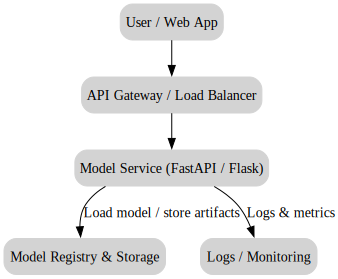

In [21]:
dot = Digraph(comment="Recommendation System Deployment", format="png")
dot.attr('node', shape='box', style='rounded,filled', color='lightgrey')

# Nodes
dot.node('A', 'User / Web App')
dot.node('B', 'API Gateway / Load Balancer')
dot.node('C', 'Model Service (FastAPI / Flask)')
dot.node('D', 'Model Registry & Storage')
dot.node('E', 'Logs / Monitoring')

# Edges
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D', label='Load model / store artifacts',  fontsize="14pt")
dot.edge('C', 'E', label='Logs & metrics',  fontsize="14pt")

dot


## Deployment Flow

### Deployment Flow Summary

1. **Model Packaging:** The trained recommender is serialized using `pickle` or `joblib`.
2. **Service Startup:** The API server loads the latest model artifact on startup.
3. **Prediction Request:** When a user visits the site, the frontend sends a request with their session or product history.
4. **Model Inference:** The model service computes and returns the top-N product recommendations.
5. **Feedback Logging:** User interactions (clicks, purchases) are logged for future retraining.


## Model Versioning & Tracking

## Model Versioning and Tracking

For this prototype, we can maintain a **simple versioning scheme** by saving trained model artifacts with version tags (e.g., `recommender_v1.pkl`, `recommender_v2.pkl`).

In a production setup, this could be extended using:
- **MLflow** or **Weights & Biases** for experiment tracking
- A **model registry** for controlled rollout of new versions
- **Scheduled retraining** triggered by new data

For this case study, model versioning is mentioned conceptually but I did not implement it.


# Final Notes

## Summary

This notebook presented a full end-to-end prototype for a recommendation system, including:
- Data preparation and exploratory analysis
- Model training and evaluation
- A deployable design for real-time recommendation

The architecture and API examples are kept conceptual and interpretable to demonstrate feasibility.
